In [1]:
import QAData
from os import listdir
from os.path import isfile, join
import PassageRetrieval as pr
from json2html import *
import matplotlib
#matplotlib.use('Agg')
import pylab as plt
import nlp_utils
import time
import os
import json
import logging
from json_utils import JSONConnector
from QAData import DataSetFactory
import models
from passrtv_models import PassageRetrievalModel
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
from keras.layers import Convolution1D, Convolution2D
from keras.layers import Input, Embedding, merge, Flatten, SimpleRNN
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Activation, Input, Dense, merge, Dropout, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution1D, Convolution2D, GlobalMaxPooling2D, Activation, Input, Dense, merge, Dropout
from keras.layers import Flatten, SimpleRNN
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import Callback
from itertools import groupby
import sys
import pickle
import nlp_utils
import numpy as np
import threading
import models as models
from models import threadsafe_generator
from scipy import spatial
import nltk
from random import shuffle
import random

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
params = {
  "expriment_id" : "keras_convnet_$runid",
  "dataset_partitions" : ["train","validate","test"],
  "dataset": "TrecDataSet",
  "ground_truth_file": "/home/aerossom/passage-retrieval/experiments/gold-jakana-test.rank",
  "model" : "KerasConvNetModel_8",
  "modeldes" : "Convolutional NN with 1d input tensor cosine sim input matrix element wise multiplied by salience matrix",
  "out_folder": "/home/aerossom/passage-retrieval/experiments/",
  "working_folder": "/home/aerossom/passage-retrieval/experiments/working_files/",
  "trec_eval_path" : "/home/aerossom/trec_eval.9.0/trec_eval",
  "out_rank_file" : "keras_convnet_matrixsim_$runid.rank",
  "word2vect_path" : "/home/aerossom/datasets/word2vect/GoogleNews-vectors-negative300.bin",
  "preprocess_steps" : [],
  "method_params" : {
                      "optimizer": "rmsprop",
                      "loss":"mean_squared_error",
                      "monitor": "val_loss",
                      "verbose" : 1,
                      "positive_rate": 0.5,
            		      "epochs": 500,
            		      "batch_size": 256,
            		      "validation_size" : 64,
            		      "max_words" : 40,
            		      "patience": 50,
                      "convolution_2d" : {
                        "nb_filter": 64,
                        "nb_row": 3,
                        "nb_col": 3,
                        "subsample": 1,
                        "border_mode" : "valid",
                        "activation" : "relu"
                      },
                      "activation_2nd_Layer" : "relu",
                      "dense_4th_Layer" : 30,
                      "dropout" : 0.1,
                      "dense_6th_layer" : 1,
                      "end_layer_activation" : "sigmoid"
		    }
}

In [7]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [8]:
w2v_path = '/home/aerossom/datasets/word2vect/GoogleNews-vectors-negative300.bin'
w2v_util = nlp_utils.Word2vectUtils(w2v_path)

In [117]:
ds = DataSetFactory.loadDataSet('WikiQADataSet')
#ds = DataSetFactory.loadDataSet('TrecDataSet_TrainAll')
#ds = DataSetFactory.loadDataSet('TrecDataSet')

qa_pair = {}
qa_pair['train'] = ds.build_qa_pairs(ds.questions['train'])
qa_pair['validate'] = ds.build_qa_pairs(ds.questions['validate'])
qa_pair['test'] = ds.build_qa_pairs(ds.questions['test'])

In [118]:
import sys
import KerasConvNetModel_9
reload(KerasConvNetModel_9)
sys.path.append('../')
import KerasConvNetModel_9 as model
model_params = {"w2v": w2v_util, "runid":'test_run',  "params":params }
k_model = model.KerasConvNetModel_9(model_params)
salience_weight=1

In [119]:
#load test data
test_qxa, test_l = k_model.buildCosineSimMatrix(qa_pair['test'], ordered_matrix=1, salience_weight=1, max_terms=40)

In [126]:
from keras import models
model = models.load_model('/home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_1495780974_best.hdf5')

th


In [127]:
from nlp_utils import avg_precision
from nlp_utils import reciprocal_rank
#Make the first preditions
first_predictions = model.predict(np.array(test_qxa))
rank_file_1 = 'experiments/rankfile_0.rank'
idx_pred = 0
rank_text = ''
for key,group in groupby(qa_pair['test'], lambda x: x.qi):
    for i, qp in enumerate(group):
        rank_text += str(qp.qi) + ' 0 ' + str(qp.ai) + ' 0 ' + str(first_predictions[idx_pred][0]) + ' 0\n'
        idx_pred += 1
with open(rank_file_1, 'wb') as text_file:
    text_file.write(rank_text)

In [128]:
#Trec
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/passage-retrieval/experiments/gold-jakana-test2.rank \
experiments/rankfile_0.rank

trec_eval: No queries with both results and relevance info


In [129]:
#WikiQA
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/datasets/WikiQACorpus/WikiQA-test-filtered.ref \
experiments/rankfile_0.rank

runid                 	all	0
num_q                 	all	237
num_ret               	all	2341
num_rel               	all	283
num_rel_ret           	all	283
map                   	all	0.6368
gm_map                	all	0.5246
Rprec                 	all	0.4568
bpref                 	all	0.4559
recip_rank            	all	0.6614
iprec_at_recall_0.00  	all	0.6641
iprec_at_recall_0.10  	all	0.6641
iprec_at_recall_0.20  	all	0.6641
iprec_at_recall_0.30  	all	0.6532
iprec_at_recall_0.40  	all	0.6485
iprec_at_recall_0.50  	all	0.6485
iprec_at_recall_0.60  	all	0.6210
iprec_at_recall_0.70  	all	0.6210
iprec_at_recall_0.80  	all	0.6200
iprec_at_recall_0.90  	all	0.6200
iprec_at_recall_1.00  	all	0.6200
P_5                   	all	0.2017
P_10                  	all	0.1152
P_15                  	all	0.0782
P_20                  	all	0.0595
P_30                  	all	0.0398
P_100                 	all	0.0119
P_200                 	all	0.0060
P_500                 	all	0.0024
P_1000                	all	0.0

In [130]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [131]:
from operator import itemgetter

def getMostInformativeTerms(model, w2vutil, base_terms, target_terms, max_terms=40, num_terms=5):
    inf_terms = ' '
    #q_vect = w2vutil.transform2Word2Vect(base_terms)
    #a_vect = w2vutil.transform2Word2Vect(target_terms)
    distance = model.composed_similarity(w2vutil.w2v_model, base_terms, target_terms, \
                    wg_wordnet=1, wg_levenshtein=1, maxterms=max_terms)
    #spatial.distance.cdist(q_vect[0:max_terms], a_vect[0:max_terms], 'cosine')
    for x in range(num_terms):
        #Calculate distance matrix
        idx = max([(distance[i,j],(i,j)) for i, row in enumerate(distance[:,]) for j, col in enumerate(row)], key=itemgetter(0)) 
        try:
            inf_terms += target_terms[idx[1][1]] + ' '
            distance[:,idx[1][1]] = -np.inf
        except:
            print idx, 'base(',base_terms,') - target(',target_terms,')'
            pass
        #print inf_terms
        #print distance
        if x >= len(base_terms)-1:
            break
    #print inf_terms
    new_q_terms = sorted(set(base_terms+inf_terms.split()))
    return ' '.join(new_q_terms)

In [132]:
def removeStop(sentence):
    w = ' '.join([word for word in sentence.split() if word not in (stopwords.words('english'))])
    return w

In [133]:
def getNewPairs(k_model,w2v_util, pairs, a_best, q_stop, a_stop, ab_stop, num_words):
    second_qapair = []
    for pair in pairs:
        q_1 = pair.q.split() 
        answer = pair.a
        if q_stop == 1:
            q_1 = [word for word in pair.q.split() if word not in (stopwords.words('english'))]
        a_1 = a_best.split()
        if a_stop == 1:
            a_1 = [word for word in a_best.split() if word not in (stopwords.words('english')) ]
        if ab_stop == 1:
            answer = removeStop(answer)
        words = getMostInformativeTerms(k_model,w2v_util, q_1, a_1, 40, num_words)
        #print sorted(set(q_1+words.split()))
        new_q = ' '.join(sorted(set(q_1+words.split())))
        second_qapair += [QAPair(pair.qi, new_q,pair.ai,answer,qp.l)]
    return second_qapair

In [ ]:
from QAData import QAPair

first_map = []
second_map = []
final_1_predictions = []
final_2_predictions = []
ids_q = []

for key,group in groupby(qa_pair['test'], lambda x: x.qi):
    first_qapair = []
    for qp in group:
        first_qapair.append(qp)
    # Get first predictions without rerank
    first_qxa, first_l = k_model.buildCosineSimMatrix(first_qapair, ordered_matrix=1, salience_weight=1, max_terms=40)
    first_predictions = model.predict(np.array(first_qxa))
    first_map.append(avg_precision(first_l, first_predictions))
    final_1_predictions.extend(first_predictions)
    # Get second preditions taking into account the pseudo relevance feedback
    maxq = np.argmax(first_predictions)
    #a_1 = ' '.join([word for word in first_qapair[maxq].a.split() ])
    #a_1_m = 
    #a_1 = ' '.join([word for word in first_qapair[maxq].a.split() if word not in (stopwords.words('english'))])
    #second_qapair = [ QAPair(qp.qi, \
    #                  getMostInformativeTerms(k_model, w2v_util, removeStop(qp.q).split(), a_1.split(), max_terms=40, num_terms=10),\
    #                  qp.ai, qp.a, qp.l) for qp in first_qapair ]
    second_qapair = [ QAPair(qp.qi, \
                      first_qapair[maxq].a,\
                      qp.ai, qp.a, qp.l) for qp in first_qapair ]
    #print first_qapair[0].q
    #print second_qapair[0].q
    second_qxa, second_l = k_model.buildCosineSimMatrix(second_qapair, ordered_matrix=1, salience_weight=1, max_terms=40)
    second_predictions = first_predictions + (0.7*model.predict(np.array(second_qxa)))
    #second_predictions[maxq] = 1.0
    second_map.append(avg_precision(second_l, second_predictions))
    final_2_predictions.extend(second_predictions)
    map1 = first_map[len(first_map)-1]
    map2 = second_map[len(second_map)-1]
    #print first_qapair[0].qi, ' l=',sum(first_l), 'map_1: ', first_map[len(first_map)-1] ,' map_2: ', second_map[len(second_map)-1]
    #print first_map, second_map
    #print 'map1(',map1,') - map2(',map2,")"
    print len(second_l), '  , Map 1 = ', sum(first_map)/len(first_map), ', Map 2 = ' , sum(second_map)/len(second_map)

6   , Map 1 =  1.0 , Map 2 =  1.0
11   , Map 1 =  0.5 , Map 2 =  0.5
6   , Map 1 =  0.666666666667 , Map 2 =  0.666666666667
5   , Map 1 =  0.75 , Map 2 =  0.75
22   , Map 1 =  0.658611111111 , Map 2 =  0.648236567354
22   , Map 1 =  0.548842592593 , Map 2 =  0.540197139462
17   , Map 1 =  0.470436507937 , Map 2 =  0.463026119539
4   , Map 1 =  0.411631944444 , Map 2 =  0.405147854596
7   , Map 1 =  0.365895061728 , Map 2 =  0.360131426308
8   , Map 1 =  0.429305555556 , Map 2 =  0.424118283677
10   , Map 1 =  0.435732323232 , Map 2 =  0.415865106373
18   , Map 1 =  0.399421296296 , Map 2 =  0.381209680842
7   , Map 1 =  0.368696581197 , Map 2 =  0.351885859239
6   , Map 1 =  0.342361111111 , Map 2 =  0.326751155007
3   , Map 1 =  0.319537037037 , Map 2 =  0.304967744674
14   , Map 1 =  0.299565972222 , Map 2 =  0.285907260632
15   , Map 1 =  0.281944444444 , Map 2 =  0.269089186477
12   , Map 1 =  0.266280864198 , Map 2 =  0.254139787228
20   , Map 1 =  0.252266081871 , Map 2 =  0.240

In [ ]:
rank_file_1 = 'experiments/rankfile_1.rank'
idx_pred = 0
rank_text = ''
for key,group in groupby(qa_pair['test'], lambda x: x.qi):
    for i, qp in enumerate(group):
        rank_text += str(qp.qi) + ' 0 ' + str(qp.ai) + ' 0 ' + str(final_2_predictions[idx_pred][0]) + ' 0\n'
        idx_pred += 1
with open(rank_file_1, 'wb') as text_file:
    text_file.write(rank_text)

In [158]:
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/passage-retrieval/experiments/gold-jakana-test2.rank experiments/rankfile_1.rank

trec_eval: No queries with both results and relevance info


In [159]:
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/datasets/WikiQACorpus/WikiQA-test-filtered.ref \
experiments/rankfile_1.rank

runid                 	all	0
num_q                 	all	237
num_ret               	all	2341
num_rel               	all	283
num_rel_ret           	all	283
map                   	all	0.6349
gm_map                	all	0.5203
Rprec                 	all	0.4589
bpref                 	all	0.4567
recip_rank            	all	0.6572
iprec_at_recall_0.00  	all	0.6598
iprec_at_recall_0.10  	all	0.6598
iprec_at_recall_0.20  	all	0.6598
iprec_at_recall_0.30  	all	0.6494
iprec_at_recall_0.40  	all	0.6446
iprec_at_recall_0.50  	all	0.6446
iprec_at_recall_0.60  	all	0.6209
iprec_at_recall_0.70  	all	0.6209
iprec_at_recall_0.80  	all	0.6203
iprec_at_recall_0.90  	all	0.6203
iprec_at_recall_1.00  	all	0.6203
P_5                   	all	0.2059
P_10                  	all	0.1148
P_15                  	all	0.0782
P_20                  	all	0.0593
P_30                  	all	0.0398
P_100                 	all	0.0119
P_200                 	all	0.0060
P_500                 	all	0.0024
P_1000                	all	0.0

In [ ]:
history

In [20]:
%matplotlib inline
# Print learning history
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'dict' object has no attribute 'history'

In [17]:
history.history

{'MAP': [0.50040411122804629, 0.52189223593768197, 0.55762187871781732],
 'MRR': [0.5037535065417272, 0.5279446569060693, 0.5645427026029268],
 'acc': [0.4765625, 0.4921875, 0.54296875],
 'loss': [0.25362694263458252, 0.25330552458763123, 0.24734991788864136],
 'val_acc': [0.5, 0.515625, 0.484375],
 'val_loss': [0.25115877389907837, 0.24868617951869965, 0.24784004688262939]}

In [23]:
with open('out_file', 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

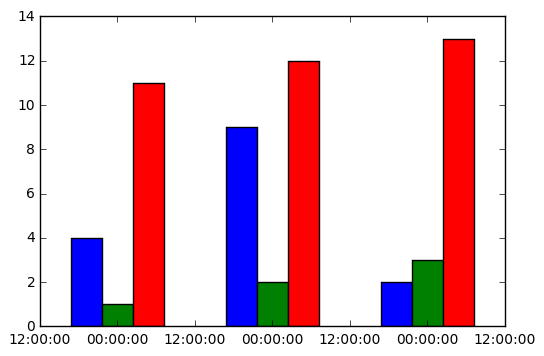

In [254]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

x = [datetime.datetime(2011, 1, 4, 0, 0),
     datetime.datetime(2011, 1, 5, 0, 0),
     datetime.datetime(2011, 1, 6, 0, 0)]
x = date2num(x)

y = [4, 9, 2]
z=[1,2,3]
k=[11,12,13]

ax = plt.subplot(111)
ax.bar(x-0.2, y,width=0.2,color='b',align='center')
ax.bar(x, z,width=0.2,color='g',align='center')
ax.bar(x+0.2, k,width=0.2,color='r',align='center')
ax.xaxis_date()

plt.show()

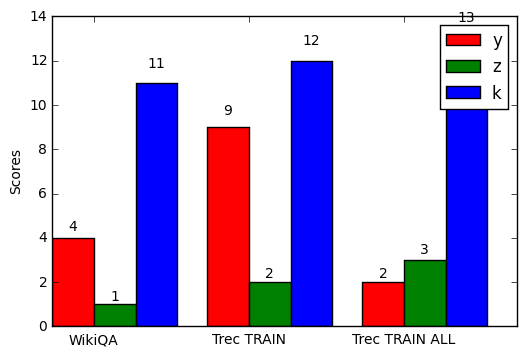

In [256]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [4, 9, 2]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [1,2,3]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [11,12,13]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('WikiQA', 'Trec TRAIN', 'Trec TRAIN ALL') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()